In [1]:
#default_exp lit_model

# LitModel
> Lit model API

In [1]:
%load_ext autoreload
%autoreload 2

## Lit Model

In [47]:
#export
from loguru import logger
from pytorch_lightning.core.lightning import LightningModule
import torch
from datetime import datetime, timedelta
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
import os
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from lit_classifier.loss import FocalLoss, BinaryFocalLoss
import os.path as osp

In [55]:
# isinstance(torch.optim.Adam(model.parameters()), torch.optim.Optimizer)

In [59]:
def get_optim_cfg(epochs, steps_per_ep, lr=2e-3, init_lr=0.5, min_lr=0.2, interval='step', optim='Adam'):
    steps = epochs*steps_per_ep
    return dict(lr=lr, init_lr=init_lr, min_lr=min_lr, steps=steps, epochs=epochs, interval=interval, optim=optim)



class LitModel(LightningModule):
    def __init__(self, model, optim_cfg, num_classes=None, loss=FocalLoss()):
        super().__init__()
        self.model = model
        self.loss_fn = loss
        self.optim_cfg = optim_cfg


    def get_linear_schedule_with_warmup(self, optimizer, num_warmup_steps, num_training_steps, init_lr, min_lr, num_epochs, interval):  
        from torch.optim.lr_scheduler import LambdaLR
        def lr_lambda(current_step: int):

                
            if current_step < num_warmup_steps:
                x = (1-init_lr)*(current_step / num_warmup_steps)+init_lr
                return x
            if interval=='epoch':
                steps_per_ep = num_training_steps / num_epochs
                current_ep = current_step // steps_per_ep
                current_step = steps_per_ep*current_ep
            
            total_step = (num_training_steps-num_warmup_steps)
            current_step = current_step-num_warmup_steps
            rt = min_lr+(1-min_lr)*1-current_step/total_step
            return rt

        return LambdaLR(optimizer, lr_lambda, -1)

    def configure_optimizers(self):
        if self.optim_cfg['optim'] == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=self.optim_cfg["lr"])
        elif self.optim_cfg == 'AdamW':
            optimizer = torch.optim.AdamW(self.parameters(), lr=self.optim_cfg["lr"], 
                                          betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
        else:
            assert isinstance(self.optim_cfg['optim'], torch.optim.Optimizer) 
            optimizer = self.optim_cfg['optim']

        scheduler = {
            "scheduler": self.get_linear_schedule_with_warmup(
                optimizer,
                self.optim_cfg["steps"] * 0.15,
                self.optim_cfg["steps"],
                self.optim_cfg["init_lr"],
                self.optim_cfg["min_lr"],
                self.optim_cfg["epochs"],
                self.optim_cfg['interval']
            ),
            "interval": 'step',  # or 'epoch'
            "frequency": 1,
        }

        return [optimizer], [scheduler]

    def forward(self, x):
        return self.model(x)

    def predict_step(self, batch, batch_idx):
        x = batch
        logits = self(x)
        scores = logits.sigmoid()
        # return dict(scores=scores)
        return scores

    def validation_step(self, batch, batch_idx):
        x, y = batch[:2]
        logits = self(x)
        loss = self.loss_fn(logits, y)

        preds = logits.sigmoid().argmax(1)
        accs = (y == preds).float().mean()


        self.log("val_loss", loss, rank_zero_only=True,
                    on_step=False, on_epoch=True)
        self.log("val_acc", accs, rank_zero_only=True,
                    on_step=False, on_epoch=True)

        return loss

    def training_step(self, batch, batch_idx):
        x, y = batch[:2]
        logits = self(x)
        loss = self.loss_fn(logits, y)

        preds = logits.sigmoid().argmax(1)
        accs = (y == preds).float().mean()
        
        self.log("training_loss", loss, prog_bar=True, rank_zero_only=True)
        self.log("training_accuracy", accs, prog_bar=True, rank_zero_only=True)
        return loss


class BinLitModel(LitModel):
    def validation_step(self, batch, batch_idx):
        x, y = batch[:2]
        logits = self(x).reshape(-1)
        y = y.reshape(logits.shape)
        loss = self.loss_fn(logits, y)

        preds = logits.sigmoid() > 0.5
        accs = (y == preds).float().mean()


        self.log("val_loss", loss, rank_zero_only=True,
                    on_step=False, on_epoch=True)
        self.log("val_acc", accs, rank_zero_only=True,
                    on_step=False, on_epoch=True)

        return loss

    def training_step(self, batch, batch_idx):
        x, y = batch[:2]
        logits = self(x).reshape(-1)
        y = y.reshape(logits.shape)
        loss = self.loss_fn(logits, y)

        preds = logits.sigmoid() > 0.5
        accs = (y == preds).float().mean()
        
        self.log("training_loss", loss, prog_bar=True, rank_zero_only=True)
        self.log("training_accuracy", accs, prog_bar=True, rank_zero_only=True)
        return loss


/home/anhvth8/.conda/envs/dms/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/home/anhvth8/.conda/envs/dms/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


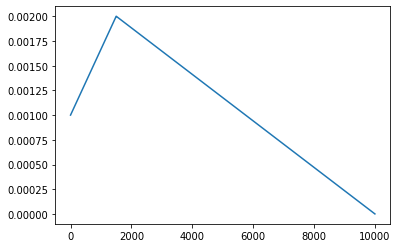

In [60]:
#hide
import timm, matplotlib.pyplot as plt


optim_cfg = get_optim_cfg(10, 1000, interval='step')
model = timm.create_model('resnet18')
model = LitModel(model, optim_cfg)
[optim], [sche] = model.configure_optimizers()
sche = sche['scheduler']
lrs = []
for i in range(10000):
    lrs.append(sche.get_lr())
    sche.step()
plt.plot(lrs)

## Get trainer

In [4]:
#export
def get_trainer(exp_name, gpus=1, max_epochs=40, distributed=False,
        monitor=dict(metric="val_acc", mode="max"), save_every_n_epochs=1, save_top_k=5,
    **trainer_kawrgs):


    now = datetime.now() + timedelta(hours=7)
    root_log_dir = osp.join(
            "lightning_logs", exp_name, now.strftime(
                "%b%d_%H_%M_%S")
        )
    filename="{epoch}-{"+monitor["metric"]+":.2f}"

    callback_ckpt = ModelCheckpoint(
        dirpath=osp.join(root_log_dir, "ckpts"),
        monitor=monitor['metric'],mode=monitor['mode'],
        filename=filename,
        save_last=True,
        every_n_epochs=save_every_n_epochs,
        save_top_k=2,
    )

    callback_tqdm = TQDMProgressBar(refresh_rate=5)
    callback_lrmornitor = LearningRateMonitor(logging_interval="step")
    plt_logger = TensorBoardLogger(
        osp.join(root_log_dir, "tb_logs"), version=now.strftime("%b%d_%H_%M_%S")
    )

    trainer = Trainer(
        gpus=gpus,
        max_epochs=max_epochs,
        strategy= "dp" if not distributed else "ddp",
        callbacks=[callback_ckpt, callback_tqdm, callback_lrmornitor],
        logger=plt_logger,**trainer_kawrgs,
    )
    return trainer

# Mnist example 

In [6]:
#hide
import os

import torch
from pytorch_lightning import LightningModule, Trainer
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

BATCH_SIZE = 1024 #if AVAIL_GPUS else 64

In [9]:
# Init DataLoader from MNIST Dataset
train_ds = MNIST(root='./', train=True, download=True, transform=transforms.Compose(
[    transforms.Lambda(lambda x: x.convert('RGB')),
    transforms.ToTensor(),]
))
test_ds = MNIST(root='./', train=False, download=True, transform=transforms.Compose(
[    
    transforms.Lambda(lambda x: x.convert('RGB')),
    transforms.ToTensor(),]
))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=10)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE*2, num_workers=10)

In [5]:
from lit_classifier import base_model
lit_model = LitModel(base_model.model_factory('mobilenetv2_035', 10, pretrained=False), loss=nn.CrossEntropyLoss())
trainer = get_trainer('test', gpus=1, distributed=False)
trainer.fit(lit_model, train_loader, test_loader)

NameError: name 'LitModel' is not defined

In [61]:
!nbdev_build_lib

Converted 00_base_model.ipynb.
Converted 01_lit_model.ipynb.
Converted 02_loss.ipynb.
